In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import pandas as pd
import numpy as np

import datetime

In [38]:
%load_ext autoreload
%autoreload 1
%aimport hobo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
ac206 = hobo.process_data('data/raw/motion-light data/ac206_2018-11-27_fixed.csv')

In [72]:
ac206[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 17:57:21-04:00,2,NaN,NaN,NaN,NaN,Logged,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00


In [41]:
occupancy = hobo.convert_to_length(ac206, 'Occupancy')

In [42]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,delta
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,NaT
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:00:02
2018-10-08 17:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:02:11


In [43]:
occ_by_day = hobo.agg_week(occupancy, 'Occupancy')

In [44]:
occ_by_day

dayofweek
0   8 days 07:06:50
1   6 days 20:54:35
2   5 days 20:32:10
3   5 days 10:00:08
4   6 days 22:11:02
5   3 days 19:05:47
6   6 days 13:15:42
Name: delta, dtype: timedelta64[ns]

Text(0.5, 1.0, 'Avg hours of occupancy in AC206 by day of week')

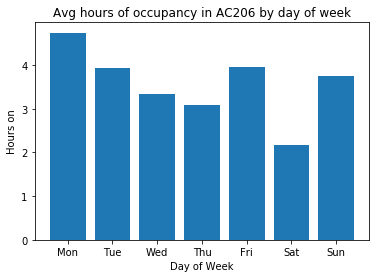

In [45]:
fig = plt.figure()
plt.bar(
    occ_by_day.index,
    occ_by_day / (6*7*np.timedelta64(1, 'h')),
)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Hours on')
plt.title('Avg hours of occupancy in AC206 by day of week')

For a more accurate average, we could normalize by:
- total number of weeks in the dataset
- total number of days in the dataset for each day of the week
- total number of hours in the dataset
- total number of hours in the dataset for each day of the week

### Total number of days

In [46]:
total_time = (ac206[-1:].index - ac206[:1].index)[0]
total_time

Timedelta('50 days 06:47:41')

In [47]:
total_hours = total_time / pd.Timedelta(1, 'h')
total_hours

1206.7947222222222

In [48]:
total_days = total_time / pd.Timedelta(1, 'd')
total_days

50.283113425925926

In [49]:
occ_by_day  # total sums

dayofweek
0   8 days 07:06:50
1   6 days 20:54:35
2   5 days 20:32:10
3   5 days 10:00:08
4   6 days 22:11:02
5   3 days 19:05:47
6   6 days 13:15:42
Name: delta, dtype: timedelta64[ns]

In [50]:
occ_by_day / (6*7*np.timedelta64(1, 'h'))  # previous estimate

dayofweek
0    4.740807
1    3.926422
2    3.346098
3    3.095291
4    3.956759
5    2.168962
6    3.744325
Name: delta, dtype: float64

In [51]:
occ_by_day / ((total_days / 7) * np.timedelta64(1, 'h'))

dayofweek
0    28.444841
1    23.558532
2    20.076587
3    18.571746
4    23.740556
5    13.013770
6    22.465952
Name: delta, dtype: float64

28 hours per day? I think we'll have to calculate total time measured per day of week.

In [53]:
ac206.groupby('dayofweek').agg(['min','max'])

#       Light      Occupancy                           date  \
            min   max   min  max       min  max                       min   
dayofweek                                                                   
0             1  4104   0.0  1.0       0.0  1.0 2018-10-08 00:00:00-04:00   
1           116  4222   0.0  1.0       0.0  1.0 2018-10-09 00:00:00-04:00   
2           327  4011   0.0  1.0       0.0  1.0 2018-10-10 00:00:00-04:00   
3           574  4015   0.0  1.0       0.0  1.0 2018-10-11 00:00:00-04:00   
4           757  4019   0.0  1.0       0.0  1.0 2018-10-12 00:00:00-04:00   
5          1043  3537   0.0  1.0       0.0  1.0 2018-10-13 00:00:00-04:00   
6          1323  4021   0.0  1.0       0.0  1.0 2018-10-14 00:00:00-04:00   

                                     
                                max  
dayofweek                            
0         2018-11-26 00:00:00-05:00  
1         2018-11-27 00:00:00-05:00  
2         2018-11-21 00:00:00-05:00  
3         2018-11-22 00:00:00-05:00  
4         2018-11-23 00:00:00-05:00  
5         2018-11-10 00:00:00-05:00  
6         2018-11-25 00:00:00-05:00

In [74]:
ac206[-1:].index

DatetimeIndex(['2018-11-27 23:45:01-05:00'], dtype='datetime64[ns, US/Eastern]', freq=None)

In [77]:
ac206[:1].index

DatetimeIndex(['2018-10-08 17:57:20-04:00'], dtype='datetime64[ns, US/Eastern]', freq=None)

In [118]:
days = pd.DataFrame(pd.date_range(start='2018-10-08', end='2018-11-27', freq='D', tz='US/Eastern'), columns=['date'])

In [120]:
days['dayofweek'] = days['date'].dt.dayofweek

In [126]:
day_totals = days.groupby('dayofweek')['date'].agg('count')  # total number of each day of the week
day_totals

dayofweek
0    8
1    8
2    7
3    7
4    7
5    7
6    7
Name: date, dtype: int64

In [127]:
occ_by_day / day_totals

dayofweek
0   1 days 00:53:21.250000
1   0 days 20:36:49.375000
2   0 days 20:04:35.714285
3   0 days 18:34:18.285714
4          0 days 23:44:26
5   0 days 13:00:49.571428
6   0 days 22:27:57.428571
dtype: timedelta64[ns]

## Plot ALL the data
(to make sure everything makes sense)

### Every day

In [54]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,delta
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,NaT
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:00:02
2018-10-08 17:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,00:02:11


In [55]:
occupancy.groupby('date')['delta'].agg('sum')

KeyError: 'date'

### All points, per week

In [56]:
ac206.index >= pd.to_datetime('2018-10-10').tz_localize('US/Eastern')

array([False, False, False, ...,  True,  True,  True])

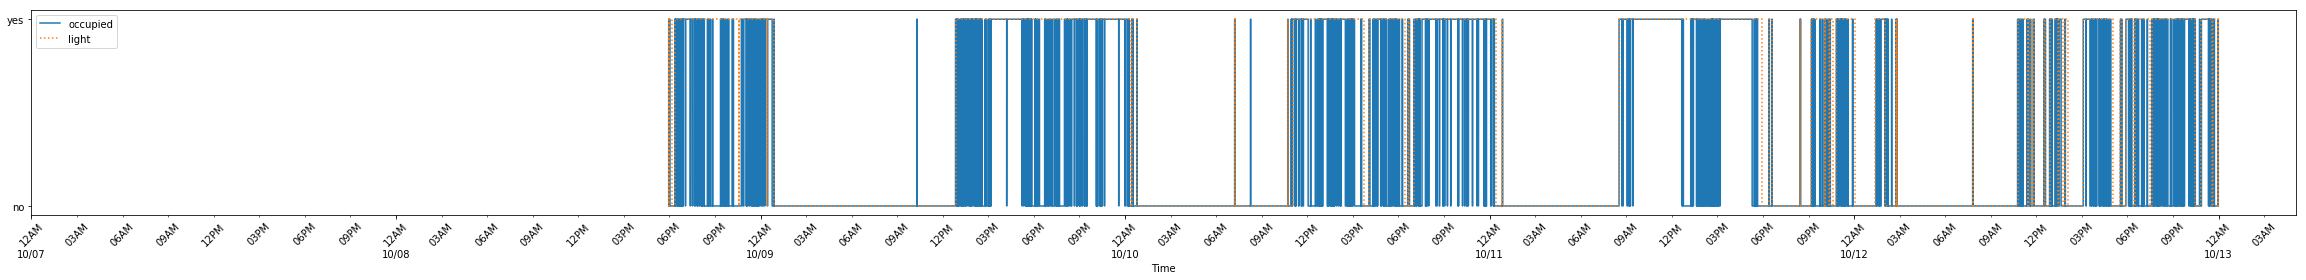

In [60]:
import pytz

def plot_range(d, tstart, tend):
    fig = plt.figure()
    data = d[(d.index >= tstart) & (d.index < tend)]
    l = ~data['Light'].isnull()
    o = ~data['Occupancy'].isnull()
    plt.plot(
        data.index[o],
        data[o]['Occupancy'],
        drawstyle='steps-post',
        label='occupied'
    )
    plt.plot(
        data.index[l],
        data[l]['Light'],
        drawstyle='steps-post',  # https://stackoverflow.com/questions/35579480/how-to-plot-square-function-with-matplotlib#35579598
        linestyle=':',
        label='light'
    )
    ax = plt.gca()
#     plt.title('Occupancy sensor')
    plt.yticks([0,1],['no','yes'])
    # plt.ylabel('Value')
    plt.xlabel('Time')
    ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='D'))
#     ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='h'), minor=True)
#     ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d', tz=pytz.timezone('US/Eastern')))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%I%p', tz=pytz.timezone('US/Eastern')))
#     plt.xticks(rotation=45)
    ax.xaxis.set_tick_params(which='major', pad=30)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)  # https://stackoverflow.com/questions/41390487/rotate-minor-ticks-in-matplotlib
    plt.legend()
#     fig.autofmt_xdate()  # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib#23009503
    fig.patch.set_facecolor('white')  # needed for dark theme https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
    plt.tight_layout()
    return fig

fig = plot_range(ac206, pd.to_datetime('2018-10-07').tz_localize('US/Eastern'), pd.to_datetime('2018-10-13').tz_localize('US/Eastern'))
fig.set_size_inches(36,4)

In [59]:
fig.savefig('neat.pdf')

In [73]:
weeks

DatetimeIndex(['2018-10-07 00:00:00-04:00', '2018-10-14 00:00:00-04:00',
               '2018-10-21 00:00:00-04:00', '2018-10-28 00:00:00-04:00',
               '2018-11-04 00:00:00-04:00', '2018-11-11 00:00:00-05:00',
               '2018-11-18 00:00:00-05:00', '2018-11-25 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', freq='W-SUN')

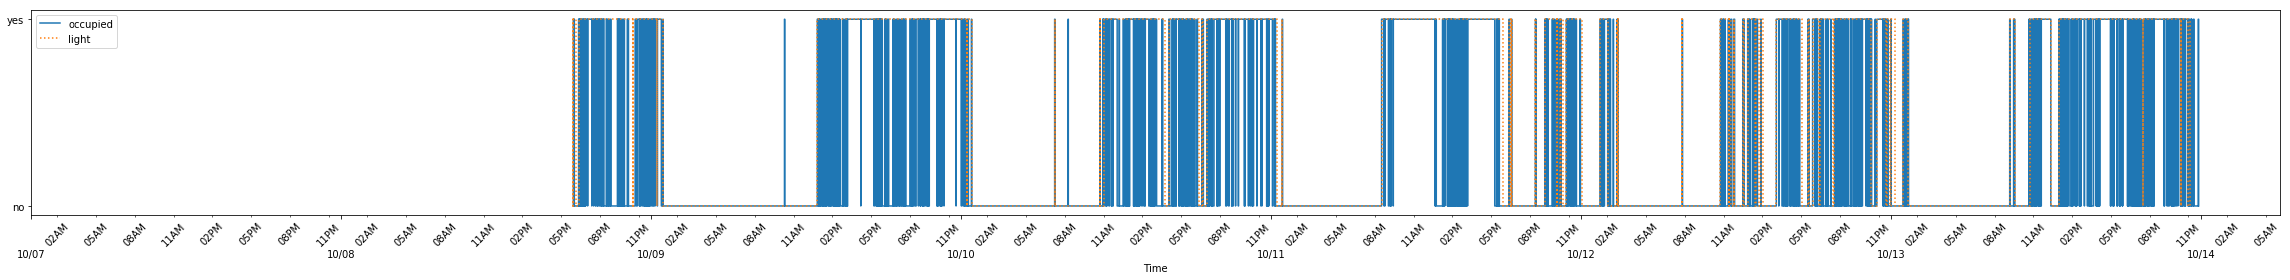

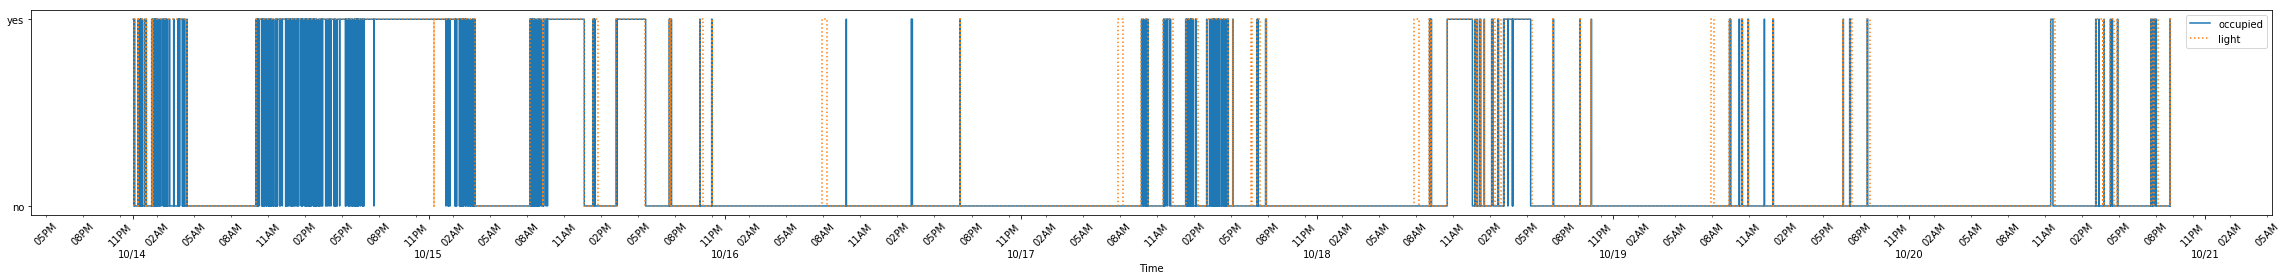

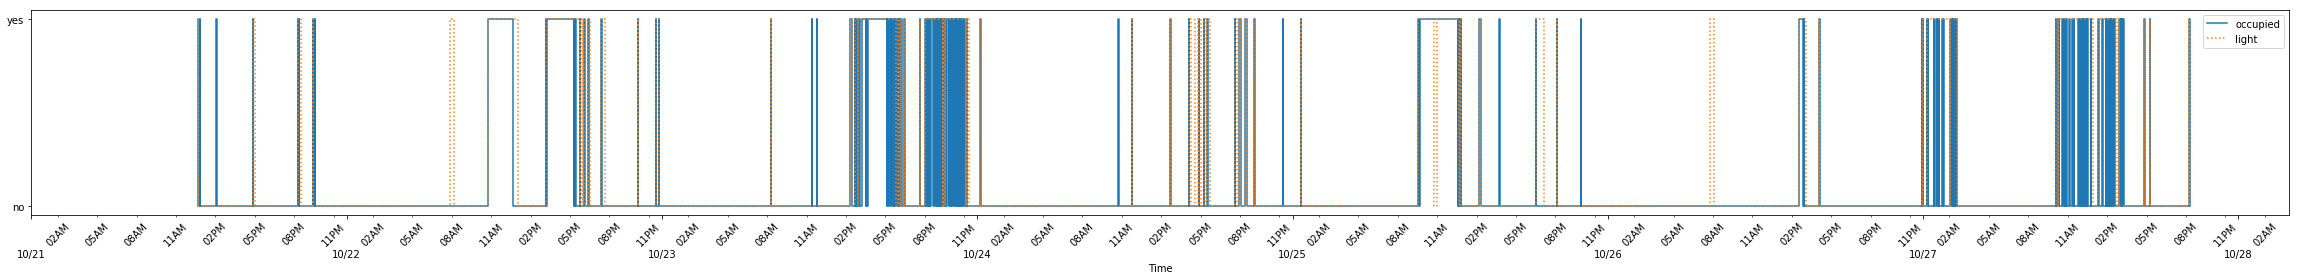

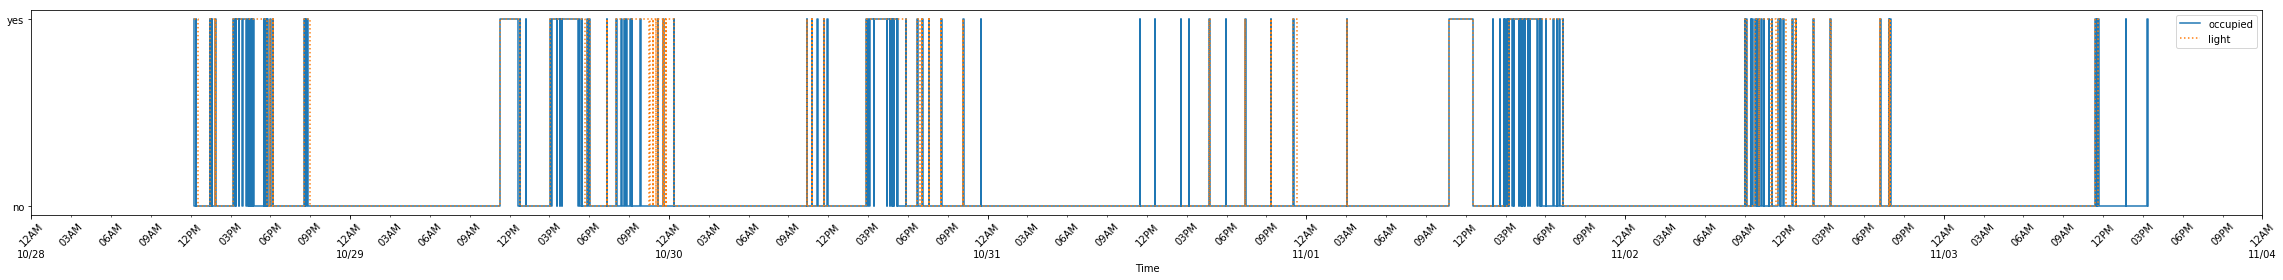

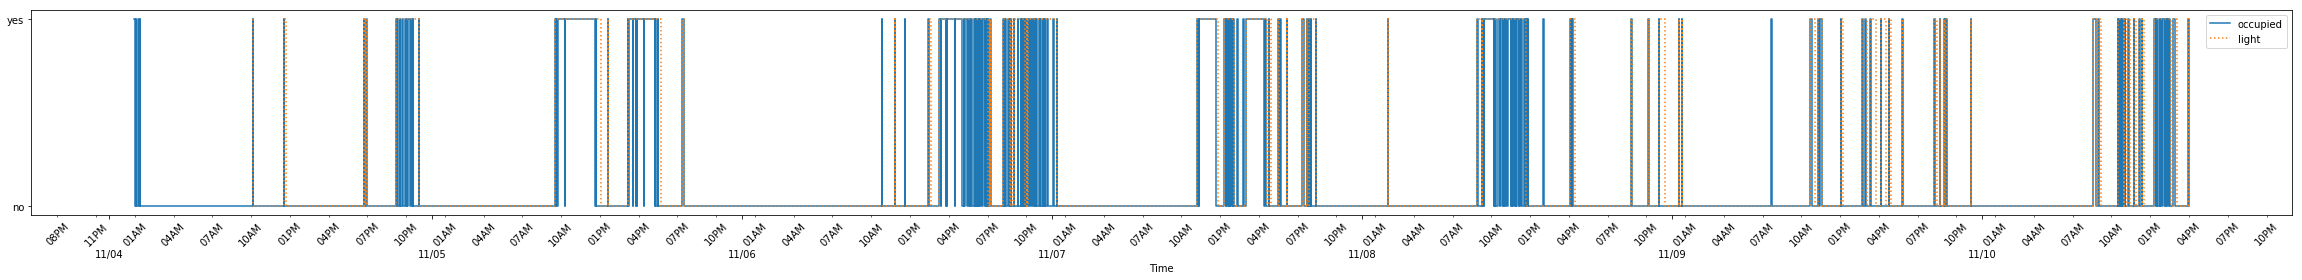

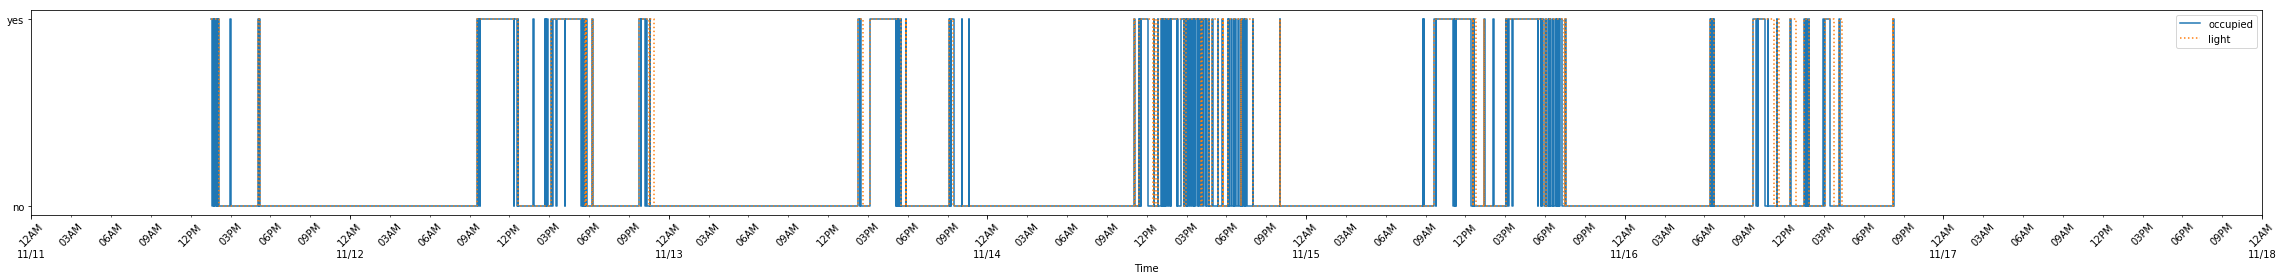

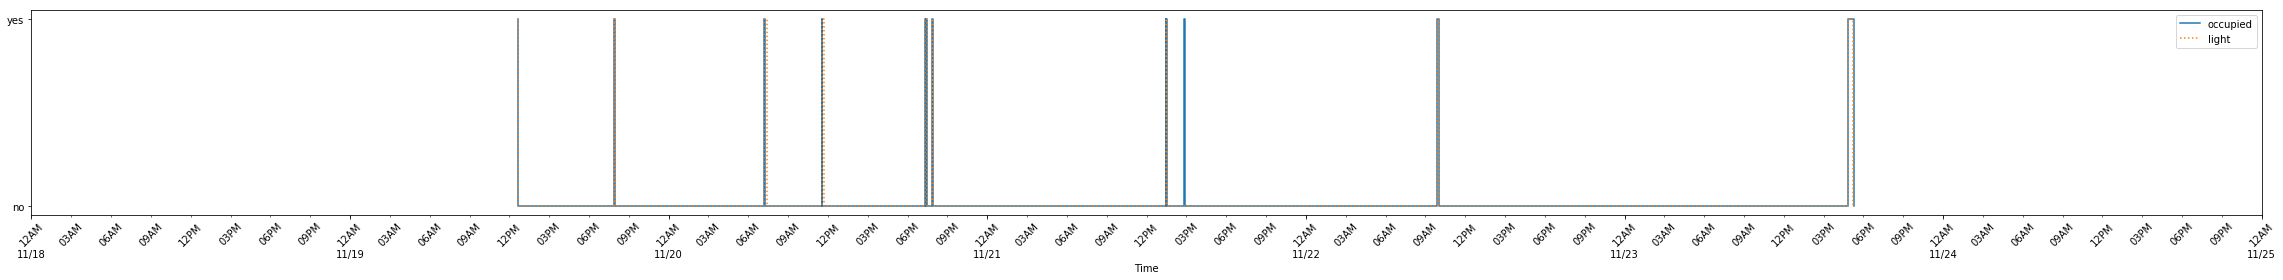

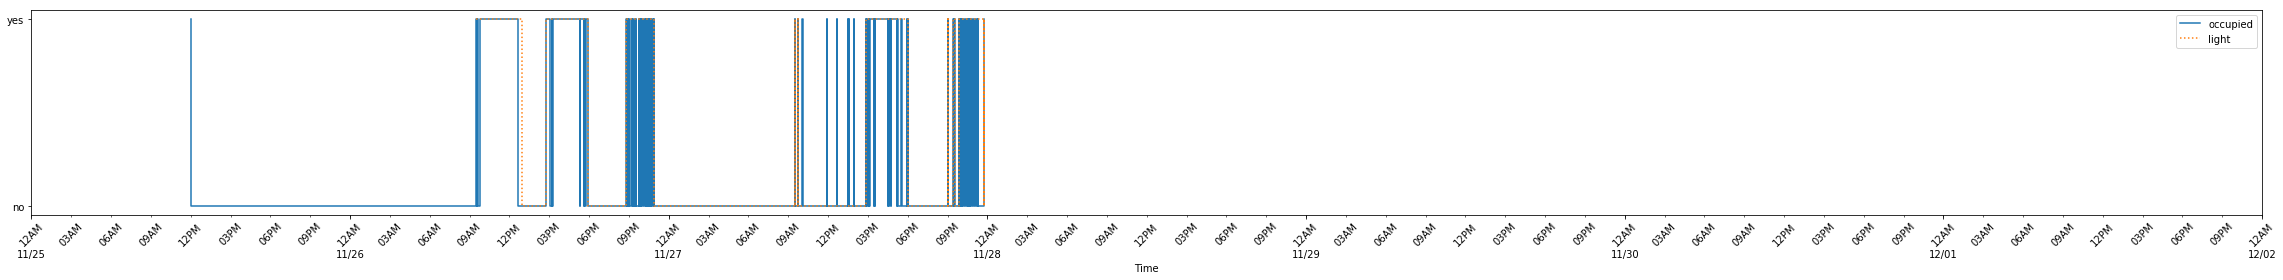

In [64]:
weeks = pd.date_range(start='2018-10-01', end='2018-11-27', freq='w', tz='US/Eastern')
for i, sunday in enumerate(weeks):
    eow = sunday + pd.to_timedelta(1, 'w')  # end of the week
    fig = plot_range(ac206, sunday, eow)
    fig.set_size_inches(36,4)
    fig.savefig('ac206_'+str(sunday.month)+'-'+str(sunday.day)+'_'+str(eow.month)+'-'+str(eow.day)+'.pdf')

In [66]:
hobo.strip_header_serial('data/raw/motion-light data/ac326_2018-11-27.csv')

'data/raw/motion-light data/ac326_2018-11-27_fixed.csv'

In [67]:
ac326 = hobo.process_data('data/raw/motion-light data/ac326_2018-11-27_fixed.csv')

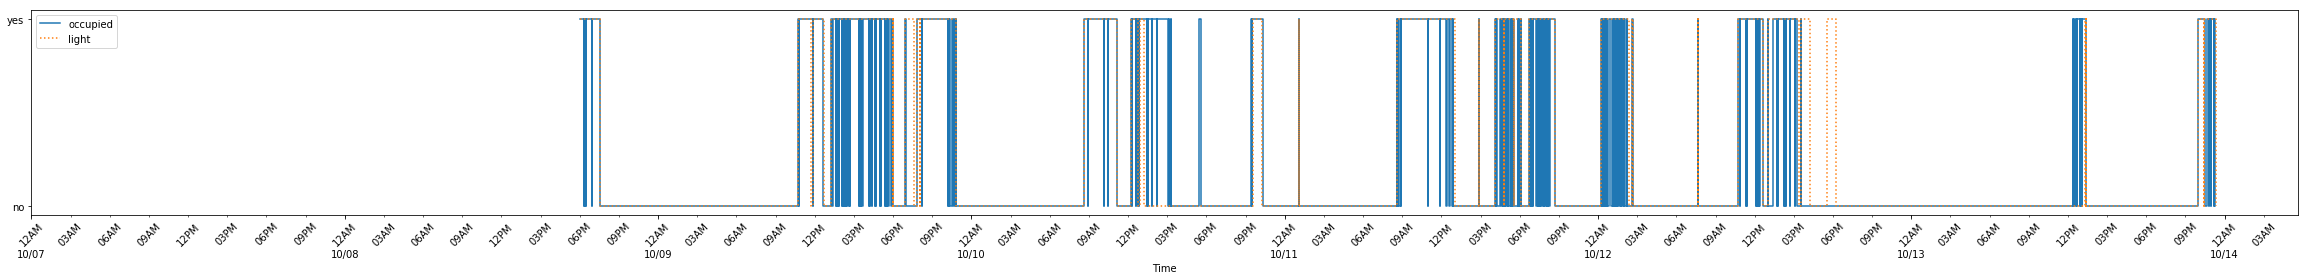

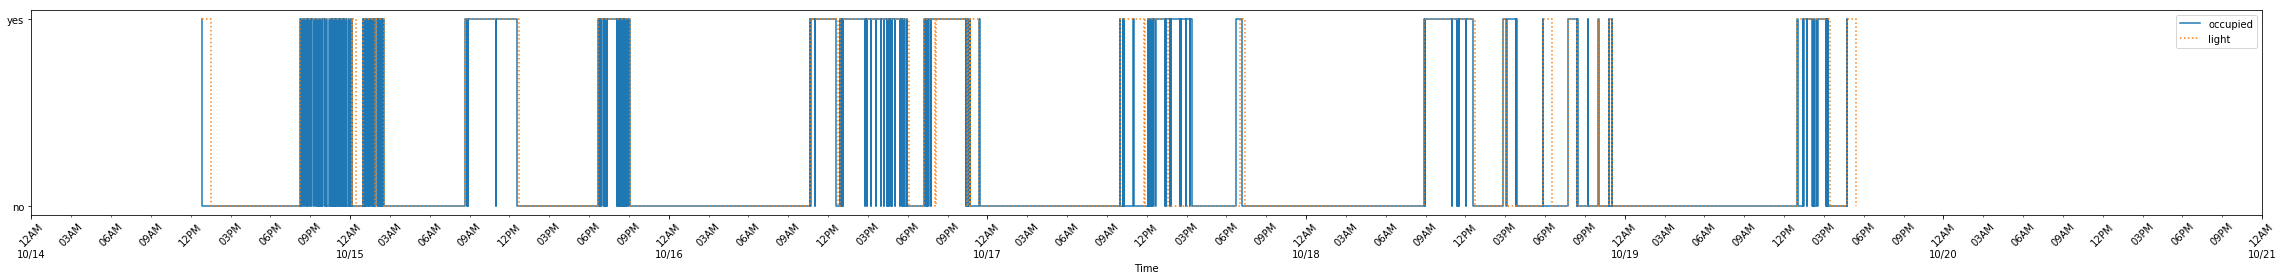

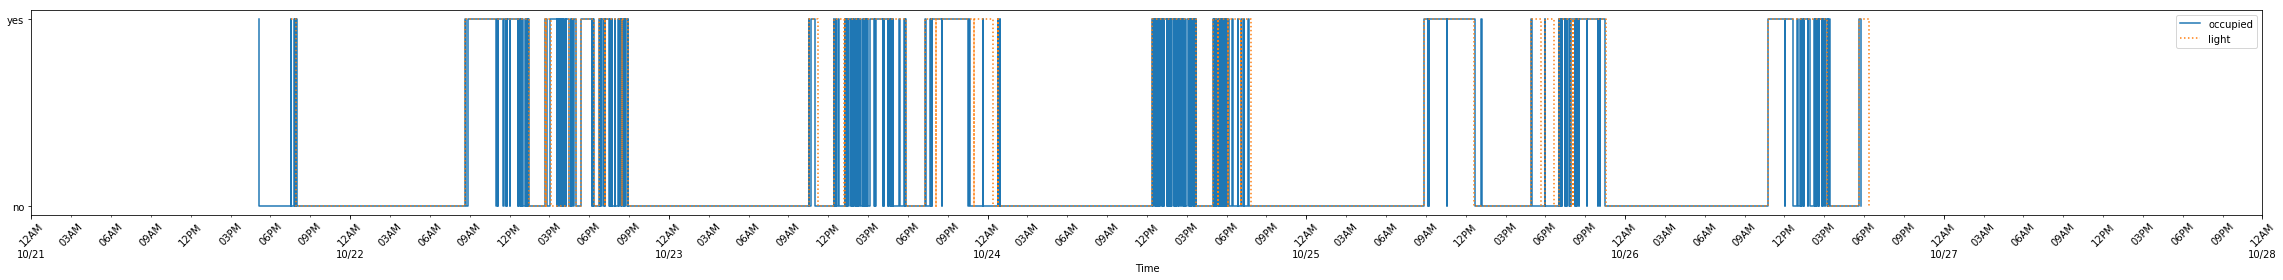

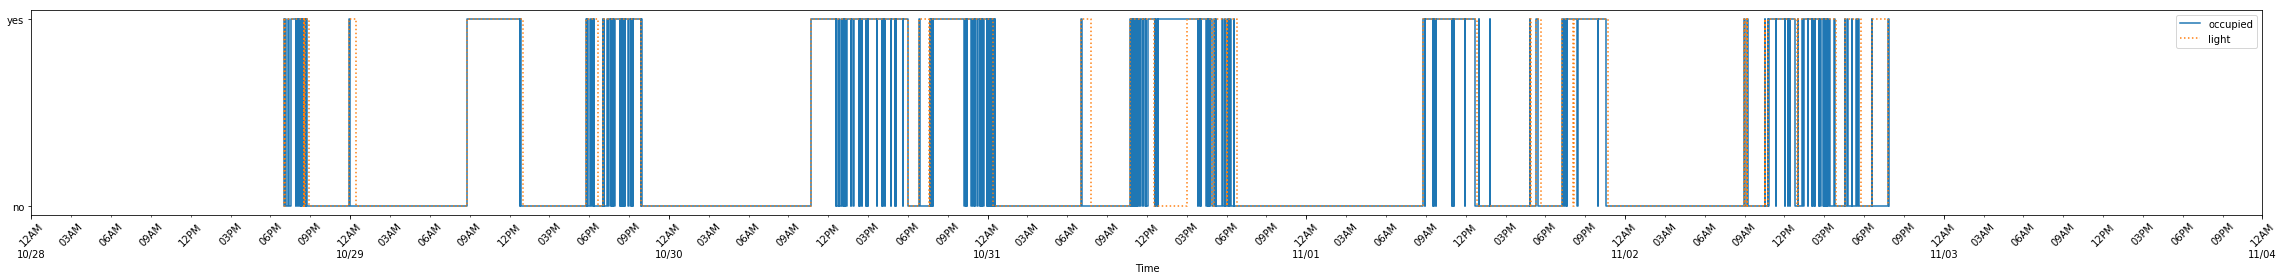

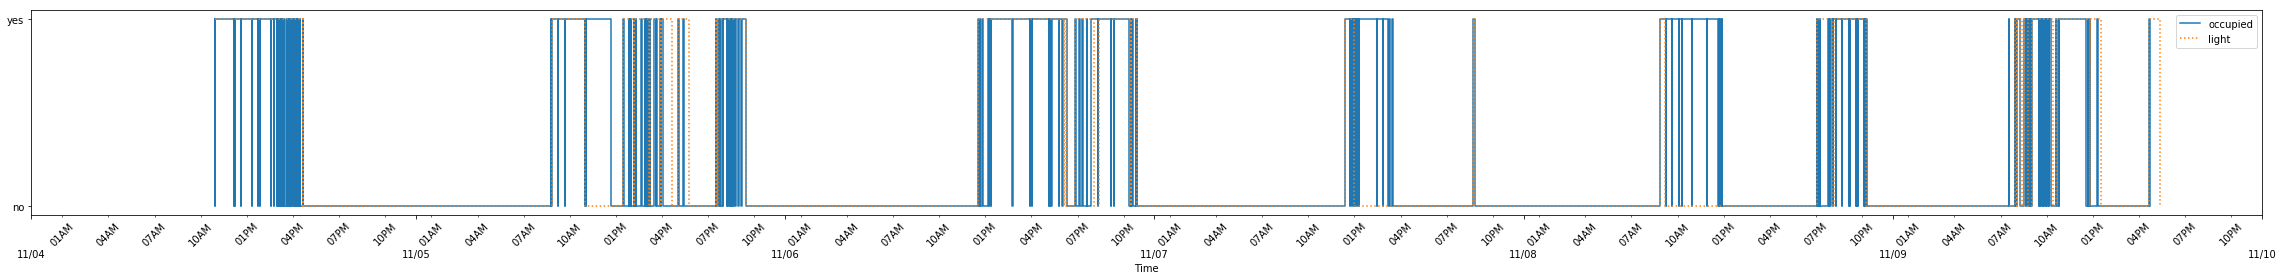

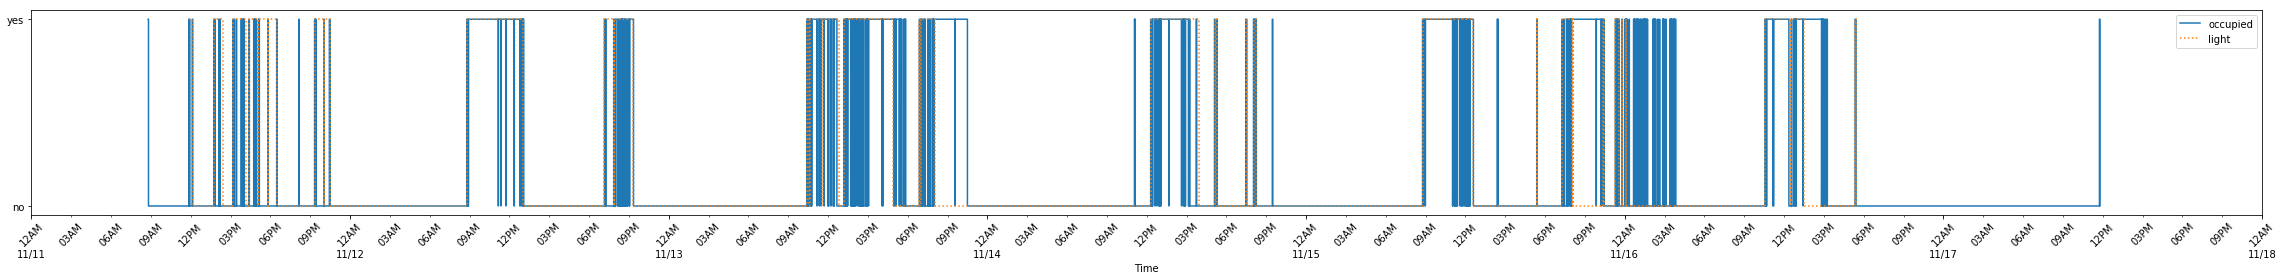

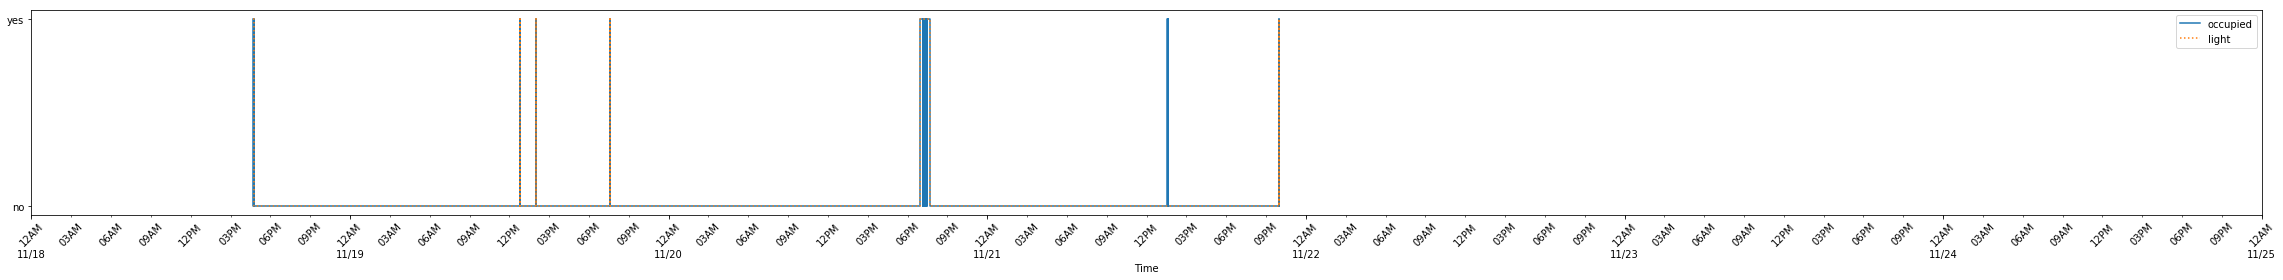

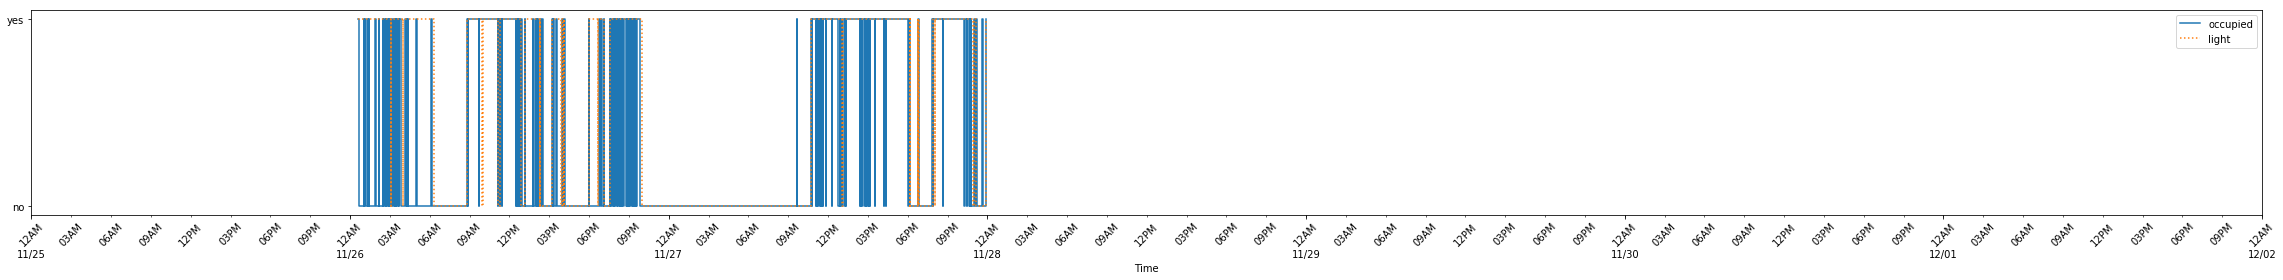

In [69]:
weeks = pd.date_range(start='2018-10-01', end='2018-11-27', freq='w', tz='US/Eastern')
for i, sunday in enumerate(weeks):
    eow = sunday + pd.to_timedelta(1, 'w')  # end of the week
    fig = plot_range(ac326, sunday, eow)
    fig.set_size_inches(36,4)
    fig.savefig('ac326_'+str(sunday.month)+'-'+str(sunday.day)+'_'+str(eow.month)+'-'+str(eow.day)+'.pdf')